In [1]:
# import here
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
import imgaug as ia
from imgaug import augmenters as iaa
%matplotlib inline

---
# Load The Data

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


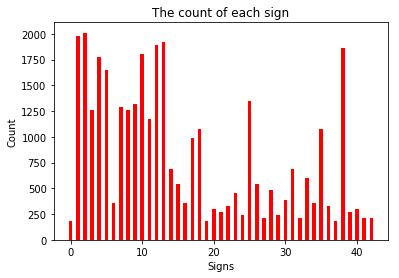

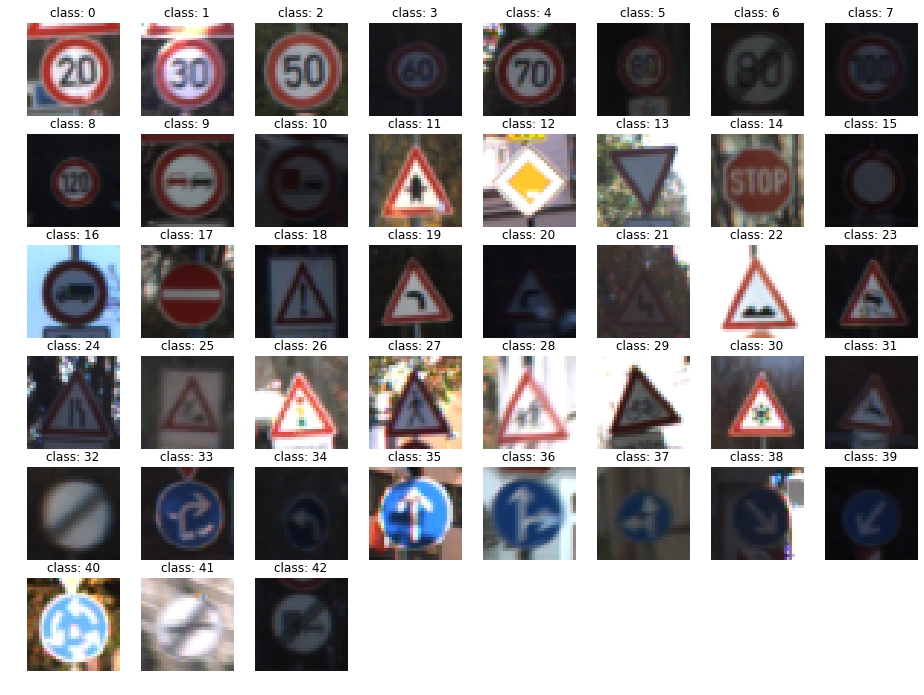

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [8]:
torch.manual_seed(1)

In [9]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, preprocess)
valid_loader = WrappedDataLoader(valid_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)

In [11]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [13]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [15]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [16]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675407	Validation loss: 3.591656	 Validation accruacy: 5.601%
[Epoch 2/20] Train loss: 3.484715	Validation loss: 3.570325	 Validation accruacy: 6.327%
[Epoch 3/20] Train loss: 3.457477	Validation loss: 3.539655	 Validation accruacy: 7.415%
[Epoch 4/20] Train loss: 3.339973	Validation loss: 3.351239	 Validation accruacy: 17.120%
[Epoch 5/20] Train loss: 2.713337	Validation loss: 2.374706	 Validation accruacy: 37.551%
[Epoch 6/20] Train loss: 1.722129	Validation loss: 1.634172	 Validation accruacy: 53.311%
[Epoch 7/20] Train loss: 1.149774	Validation loss: 1.175030	 Validation accruacy: 66.780%
[Epoch 8/20] Train loss: 0.858877	Validation loss: 0.977604	 Validation accruacy: 72.222%
[Epoch 9/20] Train loss: 0.680564	Validation loss: 0.966976	 Validation accruacy: 72.358%
[Epoch 10/20] Train loss: 0.562685	Validation loss: 0.816582	 Validation accruacy: 77.370%
[Epoch 11/20] Train loss: 0.477068	Validation loss: 0.727637	 Validation accruacy: 79.524%
[Epoch 12/2

---
# Experiment and find tuning

## Data preprocessing

In [17]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

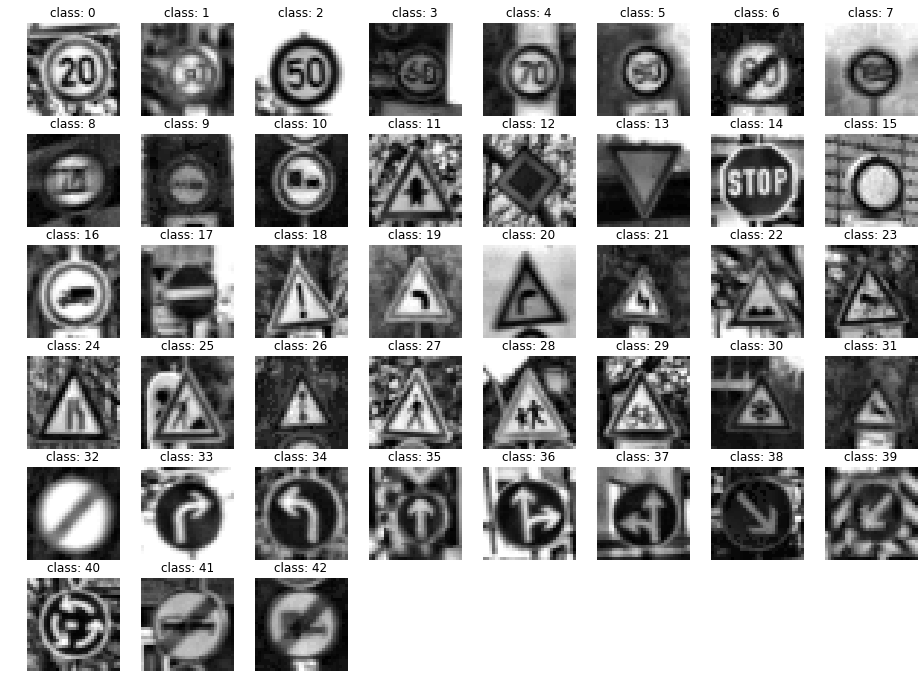

In [18]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [19]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [20]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.727780	Validation loss: 3.685289	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.526084	Validation loss: 3.554989	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.442308	Validation loss: 3.492682	 Validation accruacy: 14.490%
[Epoch 4/20] Train loss: 3.123909	Validation loss: 2.767949	 Validation accruacy: 28.458%
[Epoch 5/20] Train loss: 1.978258	Validation loss: 1.626260	 Validation accruacy: 54.218%
[Epoch 6/20] Train loss: 1.194993	Validation loss: 1.080421	 Validation accruacy: 69.002%
[Epoch 7/20] Train loss: 0.834367	Validation loss: 0.811675	 Validation accruacy: 75.283%
[Epoch 8/20] Train loss: 0.646593	Validation loss: 0.703607	 Validation accruacy: 78.685%
[Epoch 9/20] Train loss: 0.531401	Validation loss: 0.650006	 Validation accruacy: 79.025%
[Epoch 10/20] Train loss: 0.443209	Validation loss: 0.588211	 Validation accruacy: 81.859%
[Epoch 11/20] Train loss: 0.382965	Validation loss: 0.500099	 Validation accruacy: 85.306%
[Epoch 12/

## Handling imbalanced dataset

### Flipping

In [21]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [22]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)

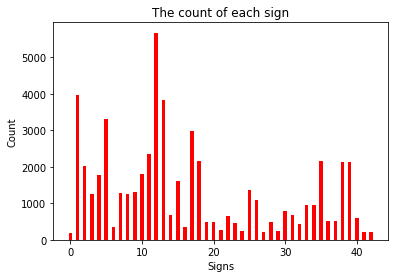

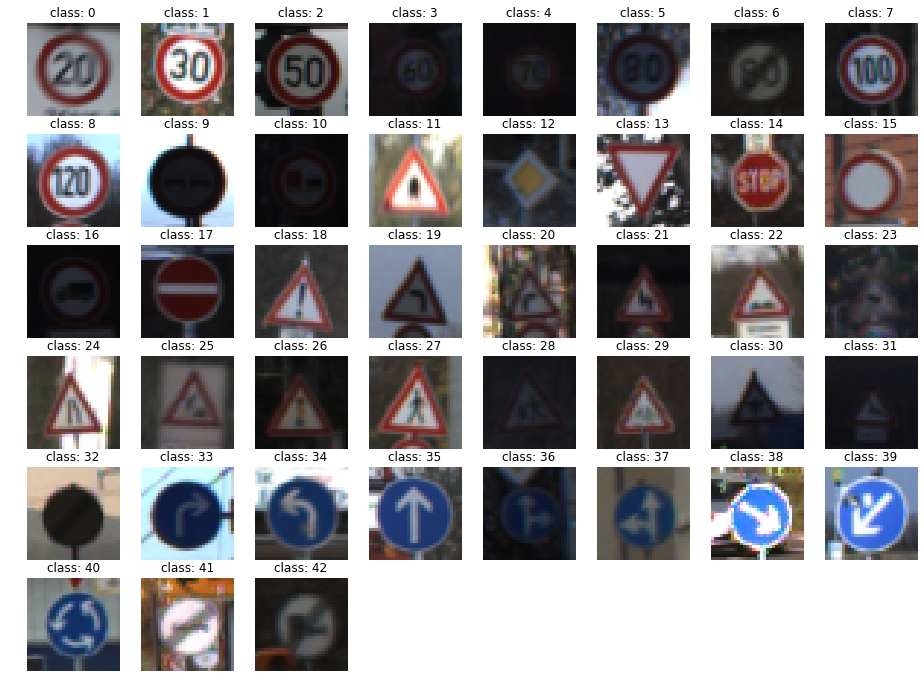

In [23]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i])

In [24]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.606553	Validation loss: 3.639135	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.379625	Validation loss: 3.599311	 Validation accruacy: 6.735%
[Epoch 3/20] Train loss: 2.682497	Validation loss: 2.165699	 Validation accruacy: 37.098%
[Epoch 4/20] Train loss: 1.286229	Validation loss: 1.274624	 Validation accruacy: 61.429%
[Epoch 5/20] Train loss: 0.827749	Validation loss: 0.959862	 Validation accruacy: 71.723%
[Epoch 6/20] Train loss: 0.622502	Validation loss: 0.734600	 Validation accruacy: 78.821%
[Epoch 7/20] Train loss: 0.488558	Validation loss: 0.622497	 Validation accruacy: 82.472%
[Epoch 8/20] Train loss: 0.398870	Validation loss: 0.624435	 Validation accruacy: 81.293%
[Epoch 9/20] Train loss: 0.332640	Validation loss: 0.524744	 Validation accruacy: 84.785%
[Epoch 10/20] Train loss: 0.283068	Validation loss: 0.491026	 Validation accruacy: 85.057%
[Epoch 11/20] Train loss: 0.246438	Validation loss: 0.473774	 Validation accruacy: 86.077%
[Epoch 12/

### Augmentation

In [30]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 10000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), preprocess)

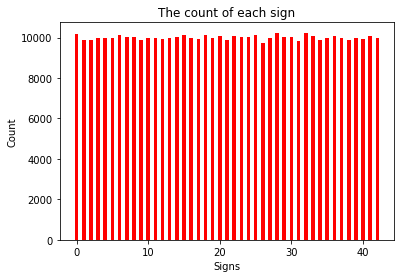

In [31]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [36]:
class ImgAug:
    def __init__(self):
        self.aug = iaa.Sequential([
            # random crops
            iaa.Crop(percent=(0, 0.1)),
            # Small gaussian blur
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Add gaussian noise.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-25, 25),
                shear=(-8, 8)
            )
        ], random_order=True)
    def __call__(self, img):
        return self.aug.augment_image(img)

In [27]:
class ImgAug:
  def __init__(self):
    self.aug = iaa.Sequential([
        # crop some of the images by 0-10% of their height/width
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))),
        # Apply affine transformations
        iaa.Sometimes(0.5, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
        # Execute 0 to 5 of the following (less important) augmenters
        iaa.SomeOf((0, 5), [
            # Convert some images into their superpixel representation,
            iaa.Sometimes(0.5, iaa.Superpixels(
                p_replace=(0, 0.5),
                n_segments=(20, 100))
            ),
            # Blur each image with varying strength
            iaa.OneOf([
                iaa.GaussianBlur((0, 2.0)),
                iaa.AverageBlur(k=(2, 4)),
                iaa.MedianBlur(k=(3, 7)),
            ]),
            # Sharpen each image, overlay the result with the original image
            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
            # Same as sharpen, but for an embossing effect.
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.0)),
            # Search in some images either for all edges or for directed edges
            iaa.Sometimes(0.5, iaa.OneOf([
                iaa.EdgeDetect(alpha=(0, 0.5)),
                iaa.DirectedEdgeDetect(
                alpha=(0, 0.5), direction=(0.0, 0.5)),
            ])),
            # Add gaussian noise to some images.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5),
            # Either drop randomly
            iaa.OneOf([
                iaa.Dropout((0.01, 0.1), per_channel=0.5),
                iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
            ]),
            # Add a value of -10 to 10 to each pixel.
            iaa.Add((-10, 10), per_channel=0.5),
            # Change brightness of images (50-150% of original value).
            iaa.Multiply((0.5, 1.5), per_channel=0.5),
            # Improve or worsen the contrast of images.
            iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
            # In some images move pixels locally around
            iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=(0.5, 2.5), sigma=0.25)),
            # In some images distort local areas with varying strength.
            iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale=(0.01, 0.05)))
        ], random_order=True)
    ], random_order=True)
      
  def __call__(self, img):
    return self.aug.augment_image(img)

In [37]:
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    ImgAug(),
#     transforms.ToPILImage(),
#     transforms.RandomApply([
#         transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
#         transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
#         transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
#         transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
#     ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

In [33]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

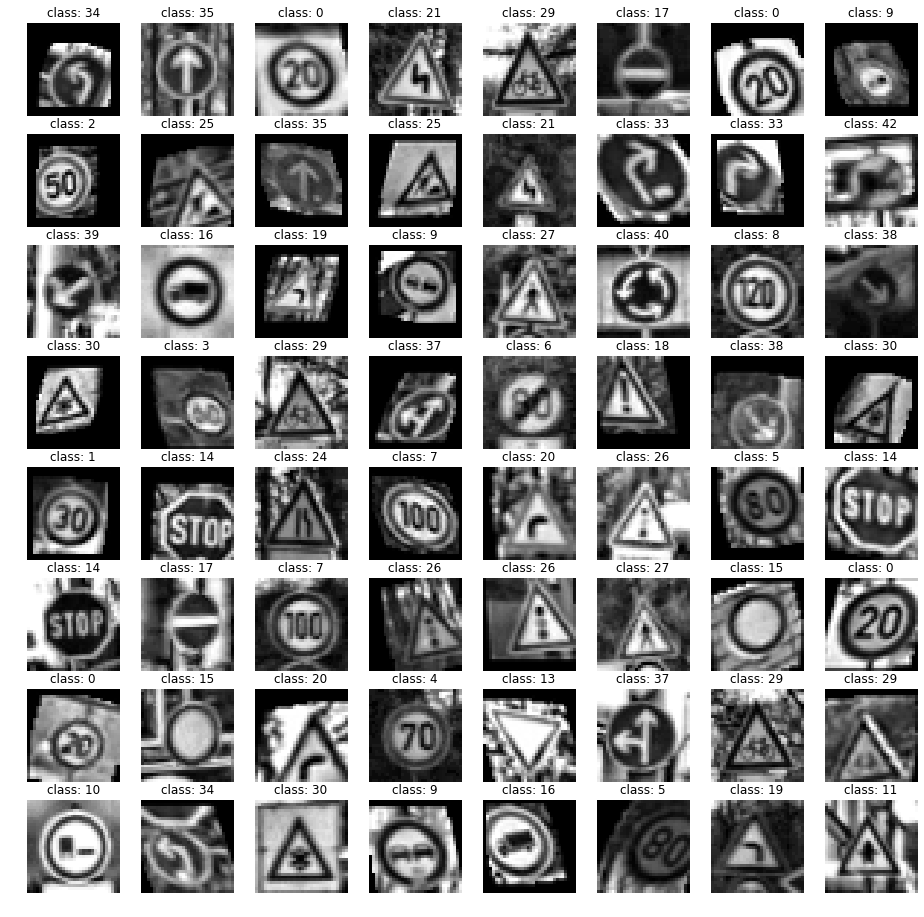

In [34]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [35]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.493892	Validation loss: 1.880324	 Validation accruacy: 48.685%
[Epoch 2/20] Train loss: 1.557238	Validation loss: 0.495331	 Validation accruacy: 87.007%
[Epoch 3/20] Train loss: 0.901468	Validation loss: 0.368541	 Validation accruacy: 88.617%
[Epoch 4/20] Train loss: 0.678297	Validation loss: 0.349004	 Validation accruacy: 89.320%
[Epoch 5/20] Train loss: 0.556573	Validation loss: 0.304060	 Validation accruacy: 90.227%
[Epoch 6/20] Train loss: 0.478135	Validation loss: 0.280656	 Validation accruacy: 91.927%
[Epoch 7/20] Train loss: 0.420085	Validation loss: 0.296210	 Validation accruacy: 91.814%
[Epoch 8/20] Train loss: 0.377906	Validation loss: 0.270385	 Validation accruacy: 93.039%
[Epoch 9/20] Train loss: 0.348742	Validation loss: 0.284484	 Validation accruacy: 92.540%
[Epoch 10/20] Train loss: 0.319634	Validation loss: 0.280924	 Validation accruacy: 92.766%
[Epoch 11/20] Train loss: 0.299976	Validation loss: 0.308341	 Validation accruacy: 92.585%
[Epoch 1

In [38]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.714650	Validation loss: 3.610370	 Validation accruacy: 5.646%
[Epoch 2/20] Train loss: 3.161357	Validation loss: 2.361579	 Validation accruacy: 29.161%
[Epoch 3/20] Train loss: 2.119799	Validation loss: 1.457062	 Validation accruacy: 53.673%
[Epoch 4/20] Train loss: 1.390312	Validation loss: 1.189067	 Validation accruacy: 62.721%
[Epoch 5/20] Train loss: 1.051937	Validation loss: 0.960622	 Validation accruacy: 70.249%
[Epoch 6/20] Train loss: 0.877468	Validation loss: 0.831292	 Validation accruacy: 72.290%
[Epoch 7/20] Train loss: 0.766574	Validation loss: 0.858061	 Validation accruacy: 72.540%
[Epoch 8/20] Train loss: 0.696232	Validation loss: 0.678658	 Validation accruacy: 77.324%
[Epoch 9/20] Train loss: 0.638342	Validation loss: 0.692439	 Validation accruacy: 77.506%
[Epoch 10/20] Train loss: 0.596596	Validation loss: 0.618510	 Validation accruacy: 80.363%
[Epoch 11/20] Train loss: 0.563075	Validation loss: 0.511358	 Validation accruacy: 83.356%
[Epoch 12

### Image normalize

In [ ]:
# Channel separation
red_chan = np.reshape(X_train[:,:,:,0], -1)/255
green_chan = np.reshape(X_train[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
# Add normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3340, 0.3117, 0.3209), (0.2717, 0.2599, 0.2658))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

### Contrast-limited adaptive histogram equalization

In [ ]:
class CLAHE:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_output
    
class CLAHE_RGB:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        
    def __call__(self, im):
        r,g,b = cv2.split(im)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        r,g,b = clahe.apply(r), clahe.apply(g), clahe.apply(b)
        return cv2.merge([r,g,b])

In [ ]:
clahe = CLAHE()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
data_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.4898, 0.4619, 0.4708), (0.2476, 0.2441, 0.2514))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

In [ ]:
clahe = CLAHE_RGB()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_RGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.4821, 0.4713, 0.4801), (0.2411, 0.2443, 0.2438))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

### Grayscale

In [ ]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

In [ ]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

gray_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
print(np.mean(gray_chan))
print(np.std(gray_chan))

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Handling imbalanced dataset

In [ ]:
# Use weighted sampler
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 43 * 5000)

In [ ]:
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.BatchSampler(torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)), 64, False)

In [ ]:
# Data augmentation
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=train_data_transforms)
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_sampler=sampler), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
balacned_y_train = np.array([], dtype=np.int64)

with torch.no_grad():
    for _, y in train_loader:
        balacned_y_train = np.append(balacned_y_train, y.cpu().numpy())

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balacned_y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    mean = 0.4715
    std = 0.2415
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Batch normalization, Dropout, Early stopping

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 2, padding=1)
        self.fc1 = nn.Linear(250 * 4 * 4, 300)
        self.fc1_bn = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(300, 43)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(-1, 250 * 4 * 4)
        x = F.elu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss

In [ ]:
model = TrafficSignNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

In [ ]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

# Spatial transformer networks

In [ ]:
class StnNet(nn.Module):
    def __init__(self):
        super(StnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=2, padding=1)
        self.fc1 = nn.Linear(250 * 4 * 4, 300)
        self.fc1_bn = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(300, 43)
        
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(-1, 250 * 4 * 4)
        x = F.elu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = StnNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

## Visualizing the STN results

In [ ]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()